In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
def calculate_eddy(width=500000, num_depth_layers=21, eta0=1, L=1e5, H=1000, a=1, b=1, rho0=1025, 
                                            f0=None, alpha_1=0.01, alpha_2=0.01, T0=20, dTdz=0.005, dSdz=0.01, taper_depth=None):
    """
    Calculate the 3D geostrophic velocity components U, V, density anomaly sigma, temperature, salinity, 
    and pressure fields for an ocean eddy.

    Parameters:
    - width: Horizontal extent of the grid (eddy scale) in meters.
    - num_depth_layers: Number of vertical layers (depth resolution).
    - eta0: Surface elevation perturbation.
    - L: Horizontal length scale of the eddy in meters.
    - H: Vertical depth scale of the eddy in meters.
    - a, b: Coefficients affecting density anomaly variation.
    - rho0: Reference density (kg/m^3).
    - f0: Coriolis parameter. If None, it will be calculated based on a latitude of -34 degrees.
    - alpha_1, alpha_2: Coefficients affecting eddy center shift with depth.
    - T0: Surface temperature (degrees Celsius).
    - dTdz: Temperature gradient with depth (degrees Celsius per meter).
    - dSdz: Salinity gradient with depth (psu per meter).
    - taper_depth: Tapering scale for vertical variations.

    Returns:
    - U, V: 3D matrices for the U and V (x- and y-components) velocity fields.
    - sigma: 3D matrix for the density anomaly.
    - T: 3D matrix for the temperature field.
    - S: 3D matrix for the salinity field.
    - P: 3D matrix for the pressure field.
    - x, y, z: Horizontal and vertical grid points.
    """

    # Constants
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))  # Coriolis parameter for latitude -34 degrees
    g = 9.81  # Gravitational acceleration (m/s^2)

    # Create 2D meshgrid for horizontal space (x, y) and depth (z)
    x = np.linspace(-width // 2, width // 2, 101)  # x-coordinates
    y = np.linspace(-width // 2, width // 2, 101)  # y-coordinates
    z = np.linspace(-H, 0, num_depth_layers)  # Depth levels from surface (0) to -H

    # Create 3D meshgrid
    x_3d, y_3d, z_3d = np.meshgrid(x, y, z, indexing='ij')

    if taper_depth is None:
        taper_factor = np.ones_like(z_3d)
    else:
        taper_factor = np.exp(z_3d / taper_depth)

    # Define the functions f(|r - r_c(z)|) and g(z)
    def f_r_rc(r, L):
        return np.exp(-r**2 / L**2)

    # Calculate the center position as a function of depth
    x_c = alpha_1 * z_3d
    y_c = alpha_2 * z_3d

    # Calculate radial distance r - r_c(z)
    r_c = np.hypot( x_3d - x_c, y_3d - y_c )

    # Temperature field
    # T = T0 + dTdz * z_3d - 2 * f_r_rc(r_c, L) * taper_factor
    T = - 2 * f_r_rc(r_c, L) * taper_factor

    # Salinity field
    S0 = 35  # Reference surface salinity (psu)
    # S = S0 + dSdz * z_3d + 1.5 * f_r_rc(r_c, L) * taper_factor
    S = 1.5 * f_r_rc(r_c, L) * taper_factor

    # Pressure field (hydrostatic pressure)
    P = -rho0 * g * z_3d

    # Density field using a simplified equation of state
    alpha = 0.0002  # Thermal expansion coefficient (1/°C)
    beta = 0.0008  # Haline contraction coefficient (1/psu)
    sigma = rho0 * (1 - alpha * (T - T0) + beta * (S - S0)) 
    sigma -= np.mean(sigma)

    # Calculate geostrophic velocity components
    dx = x[1] - x[0]  # Grid spacing in x
    dy = y[1] - y[0]  # Grid spacing in y
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy

    U = g / f0 * d_sigma_dy * taper_factor
    V = -g / f0 * d_sigma_dx * taper_factor

    U = np.flip(U, axis=2)
    V = np.flip(V, axis=2)
    sigma = np.flip(sigma, axis=2)
    T = np.flip(T, axis=2)
    S = np.flip(S, axis=2)
    P = np.flip(P, axis=2)
    z = np.flip(z)

    return U, V, sigma, T, S, P, x/1000, y/1000, z
    

In [3]:
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=None)


In [4]:
u = U[:,:,0]
v = V[:,:,0]

n_ic = 50
n_jc = 60

u1 = u[:, n_jc]
v1 = v[:, n_jc]

def find_increasing_magnitude_sublist(lst, ic, tolerance=0):
    min_radial_dist = 3
    # Initialize sublist and index list with the center element
    sublist = [lst[ic]]
    indices = [ic]
    # Move left and check if magnitude increases with tolerance, at least 3 indices
    count_left = 0
    for i in range(ic - 1, -1, -1):
        if count_left < min_radial_dist:
            sublist.insert(0, lst[i])
            indices.insert(0, i)
            count_left += 1
        elif abs(lst[i]) >= abs(sublist[0]) - tolerance:
            sublist.insert(0, lst[i])
            indices.insert(0, i)
        else:
            break    
    # Move right and check if magnitude increases with tolerance, at least 3 indices
    count_right = 0
    for i in range(ic + 1, len(lst)):
        if count_right < min_radial_dist:
            sublist.append(lst[i])
            indices.append(i)
            count_right += 1
        elif abs(lst[i]) >= abs(sublist[-1]) - tolerance:
            sublist.append(lst[i])
            indices.append(i)
        else:
            break
    return np.array(sublist), indices

dx = x[1] - x[0]
v1, v_ind = find_increasing_magnitude_sublist(v1, n_ic)
u1 = u1[v_ind]

xx = (np.array(v_ind) - n_ic) * dx
yy = np.array([y[n_jc]] * len(xx))

l = xx - xx[0]

coefficients = np.polyfit(l, v1, 1)

c, b = coefficients

a = np.polyfit(l, u1, 0)

x0 = - b / c
y0 = a / c

x0 += xx[0]
y0 += yy[0]

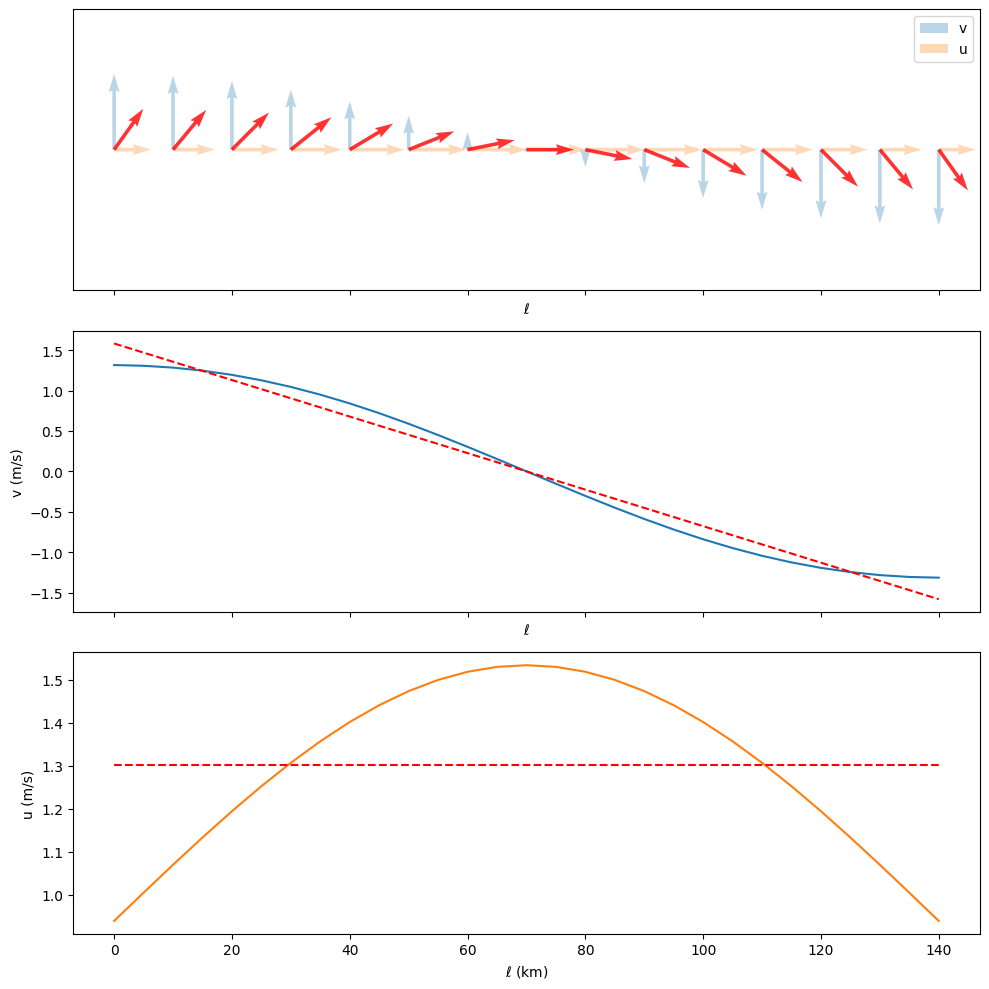

In [5]:
colors = plt.cm.tab10.colors

width = 0.004

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10,10), sharex=True)

# Plot 1
alpha = .3
spacing = 2
# axes[0].plot(l, [0] * len(l), color='r', zorder=1, alpha=0.3, linestyle='--')
axes[0].quiver(l[::spacing], [0] * len(l[::spacing]), [0]*len(v1[::spacing]), v1[::spacing], width=width, color=colors[0], alpha=alpha, label='v')
axes[0].quiver(l[::spacing], [0] * len(l[::spacing]), u1[::spacing], [0]*len(u1[::spacing]), width=width, color=colors[1], alpha=alpha, label='u')
axes[0].quiver(l[::spacing], [0] * len(l[::spacing]), u1[::spacing], v1[::spacing], width=width, alpha=0.8, color='r')
axes[0].set_xlabel(r'$\ell$')
axes[0].yaxis.set_ticks([])
axes[0].yaxis.set_tick_params(length=0)
axes[0].set_yticklabels([])
axes[0].legend()

# Plot 2
coeffs_v = np.polyfit(l, v1, 1)
fit_line_v = np.poly1d(coeffs_v)
axes[1].plot(l, v1, color=colors[0])
axes[1].plot(l, fit_line_v(l), linestyle="--", color='r')
axes[1].set_xlabel(r'$\ell$')
axes[1].set_ylabel('v (m/s)')

# Plot 3
coeffs_u = np.polyfit(l, u1, 0)
fit_line_u = np.poly1d(coeffs_u)
axes[2].plot(l, u1, color=colors[1])
axes[2].plot(l, fit_line_u(l), linestyle="--", color='r')
axes[2].set_xlabel(r'$\ell$ (km)')
axes[2].set_ylabel('u (m/s)')

# Adjust layout
plt.tight_layout()
plt.show()


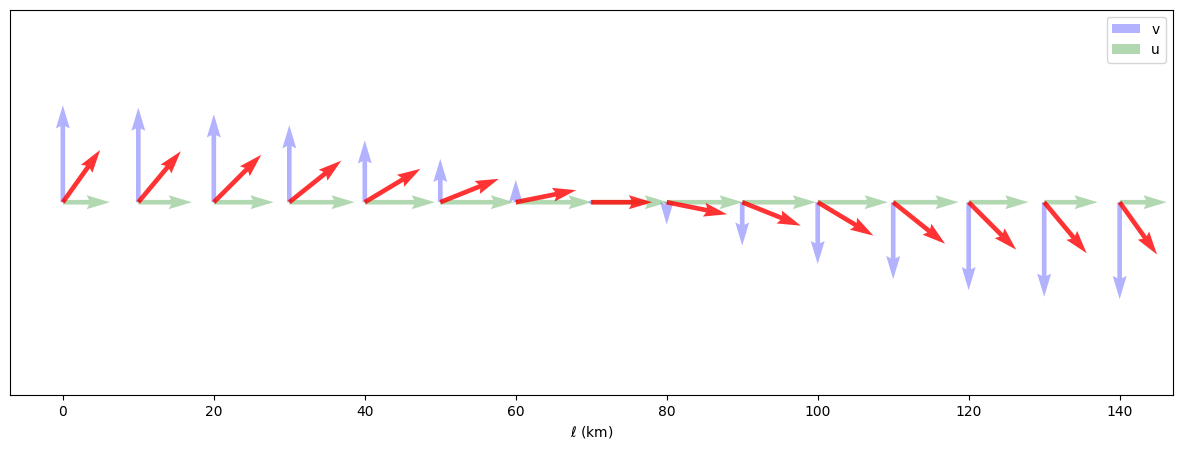

In [17]:
alpha = 0.3
spacing = 2
width = 0.004
colors = ['b', 'g']

fig, ax = plt.subplots(figsize=(15,5))

ax.quiver(l[::spacing], [0] * len(l[::spacing]), [0]*len(v1[::spacing]), v1[::spacing], width=width, color=colors[0], alpha=alpha, label='v')
ax.quiver(l[::spacing], [0] * len(l[::spacing]), u1[::spacing], [0]*len(u1[::spacing]), width=width, color=colors[1], alpha=alpha, label='u')
ax.quiver(l[::spacing], [0] * len(l[::spacing]), u1[::spacing], v1[::spacing], width=width, alpha=0.8, color='r')

ax.set_xlabel(r'$\ell$ (km)')
ax.yaxis.set_ticks([])
ax.yaxis.set_tick_params(length=0)
ax.set_yticklabels([])

ax.legend()

plt.show()



Text(0, 0.5, 'y (km)')

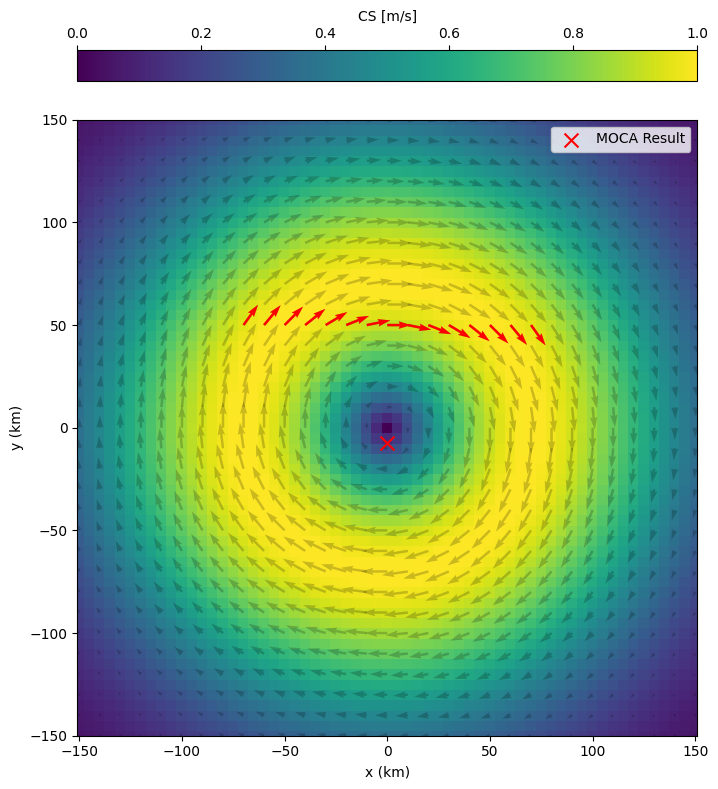

In [7]:

plt.figure(figsize=(8,10))

plt.pcolor(x, y, np.hypot(u, v))


spacing = 2
scale = 40
width = 0.004

plt.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)

# plt.plot(xx, yy, color='r', linestyle='--', zorder=1, alpha=.3)
plt.quiver(xx[::spacing], yy[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color='r')

plt.scatter(x0, y0, color='r', marker='x', s=100, label='MOCA Result')

plt.colorbar(orientation='horizontal', location='top', label='CS [m/s]')
plt.axis('equal')
plt.legend()

plt.xlim(-150, 150)
plt.ylim(-150, 150)

plt.xlabel('x (km)')
plt.ylabel('y (km)')

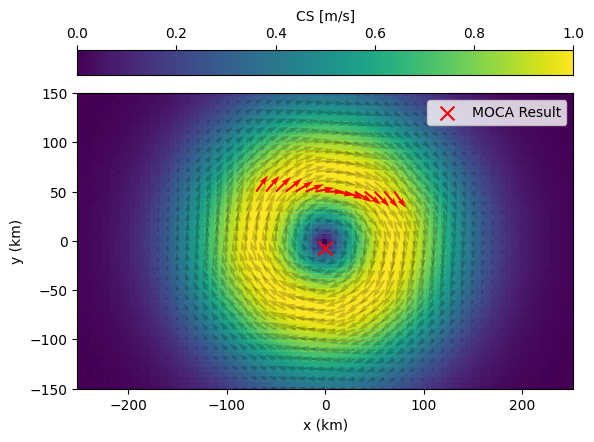

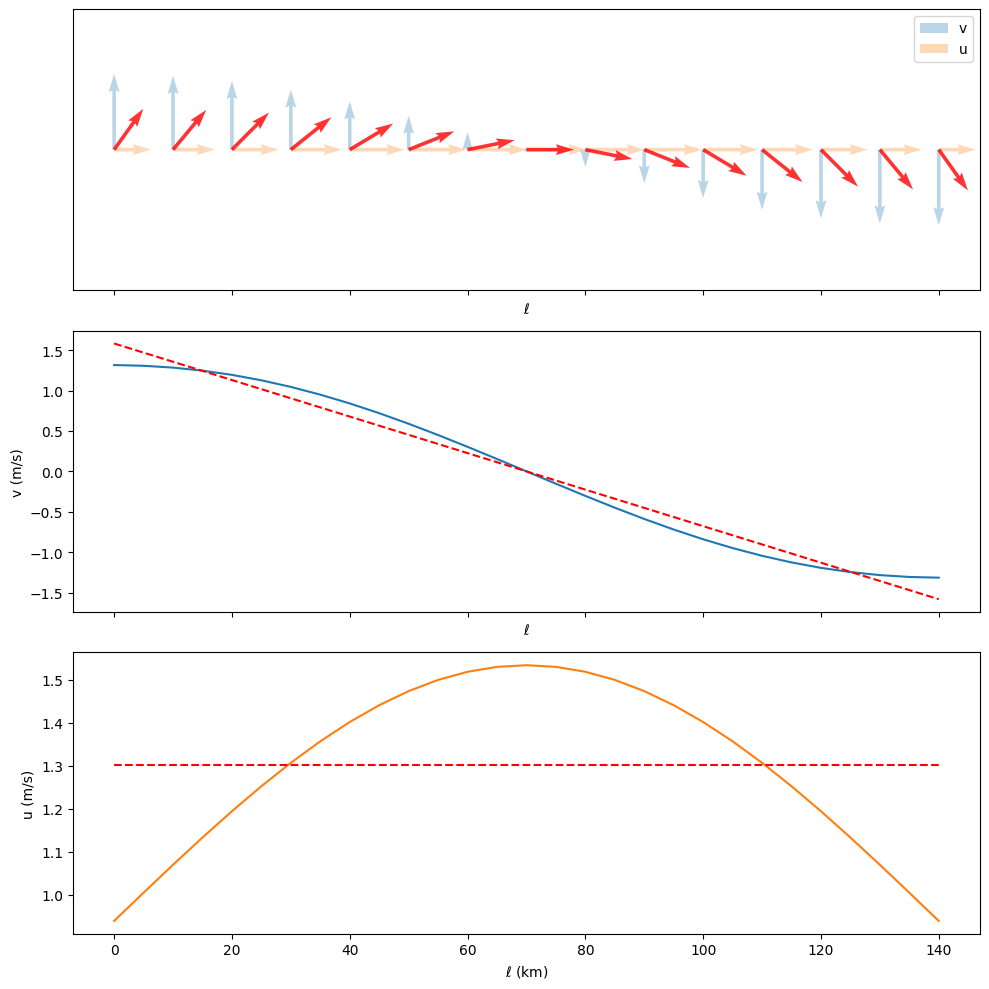

In [8]:

# size 3x3 from [:, :3]
plt.pcolor(x, y, np.hypot(u, v))

spacing = 2
scale = 40
width = 0.004

plt.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)

# plt.plot(xx, yy, color='r', linestyle='--', zorder=1, alpha=.3)
plt.quiver(xx[::spacing], yy[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color='r')

plt.scatter(x0, y0, color='r', marker='x', s=100, label='MOCA Result')

plt.colorbar(orientation='horizontal', location='top', label='CS [m/s]')
plt.axis('equal')
plt.legend()

plt.xlim(-150, 150)
plt.ylim(-150, 150)

plt.xlabel('x (km)')
plt.ylabel('y (km)')



# make these subplots in the [:, 3]
colors = plt.cm.tab10.colors

width = 0.004

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10,10), sharex=True)

# Plot 1
alpha = .3
spacing = 2
# axes[0].plot(l, [0] * len(l), color='r', zorder=1, alpha=0.3, linestyle='--')
axes[0].quiver(l[::spacing], [0] * len(l[::spacing]), [0]*len(v1[::spacing]), v1[::spacing], width=width, color=colors[0], alpha=alpha, label='v')
axes[0].quiver(l[::spacing], [0] * len(l[::spacing]), u1[::spacing], [0]*len(u1[::spacing]), width=width, color=colors[1], alpha=alpha, label='u')
axes[0].quiver(l[::spacing], [0] * len(l[::spacing]), u1[::spacing], v1[::spacing], width=width, alpha=0.8, color='r')
axes[0].set_xlabel(r'$\ell$')
axes[0].yaxis.set_ticks([])
axes[0].yaxis.set_tick_params(length=0)
axes[0].set_yticklabels([])
axes[0].legend()

# Plot 2
coeffs_v = np.polyfit(l, v1, 1)
fit_line_v = np.poly1d(coeffs_v)
axes[1].plot(l, v1, color=colors[0])
axes[1].plot(l, fit_line_v(l), linestyle="--", color='r')
axes[1].set_xlabel(r'$\ell$')
axes[1].set_ylabel('v (m/s)')

# Plot 3
coeffs_u = np.polyfit(l, u1, 0)
fit_line_u = np.poly1d(coeffs_u)
axes[2].plot(l, u1, color=colors[1])
axes[2].plot(l, fit_line_u(l), linestyle="--", color='r')
axes[2].set_xlabel(r'$\ell$ (km)')
axes[2].set_ylabel('u (m/s)')

# Adjust layout
plt.tight_layout()
plt.show()




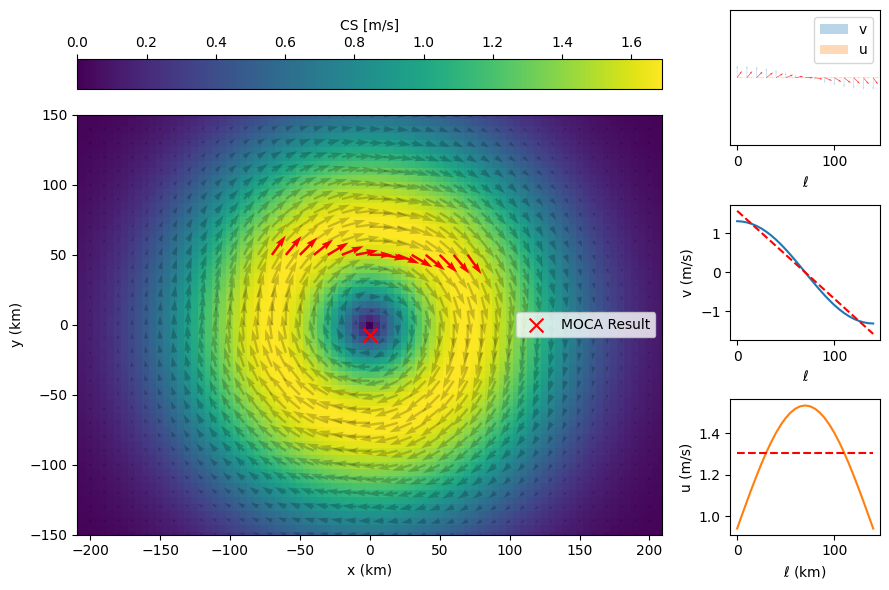

In [21]:
import matplotlib.gridspec as gridspec

# GridSpec for custom layout
fig = plt.figure(figsize=(9, 6))
gs = gridspec.GridSpec(3, 4, figure=fig)

# Large 3x3 subplot
ax_main = fig.add_subplot(gs[:, :3])
pc = ax_main.pcolor(x, y, np.hypot(u, v))
spacing = 2
scale = 40
width = 0.004
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)
ax_main.quiver(xx[::spacing], yy[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color='r')
ax_main.scatter(x0, y0, color='r', marker='x', s=100, label='MOCA Result')
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [m/s]')
ax_main.axis('equal')
ax_main.legend()
ax_main.set_xlim(-150, 150)
ax_main.set_ylim(-150, 150)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')

# 3x1 subplot column
ax1 = fig.add_subplot(gs[0, 3])
ax2 = fig.add_subplot(gs[1, 3])
ax3 = fig.add_subplot(gs[2, 3])

colors = plt.cm.tab10.colors
alpha = .3

# Subplot 1
ax1.quiver(l[::spacing], [0] * len(l[::spacing]), [0]*len(v1[::spacing]), v1[::spacing], width=width, color=colors[0], alpha=alpha, label='v')
ax1.quiver(l[::spacing], [0] * len(l[::spacing]), u1[::spacing], [0]*len(u1[::spacing]), width=width, color=colors[1], alpha=alpha, label='u')
ax1.quiver(l[::spacing], [0] * len(l[::spacing]), u1[::spacing], v1[::spacing], width=width, alpha=0.8, color='r')
ax1.set_xlabel(r'$\ell$')
ax1.yaxis.set_ticks([])
ax1.legend()

# Subplot 2
coeffs_v = np.polyfit(l, v1, 1)
fit_line_v = np.poly1d(coeffs_v)
ax2.plot(l, v1, color=colors[0])
ax2.plot(l, fit_line_v(l), linestyle="--", color='r')
ax2.set_xlabel(r'$\ell$')
ax2.set_ylabel('v (m/s)')

# Subplot 3
coeffs_u = np.polyfit(l, u1, 0)
fit_line_u = np.poly1d(coeffs_u)
ax3.plot(l, u1, color=colors[1])
ax3.plot(l, fit_line_u(l), linestyle="--", color='r')
ax3.set_xlabel(r'$\ell$ (km)')
ax3.set_ylabel('u (m/s)')

plt.tight_layout()
plt.show()








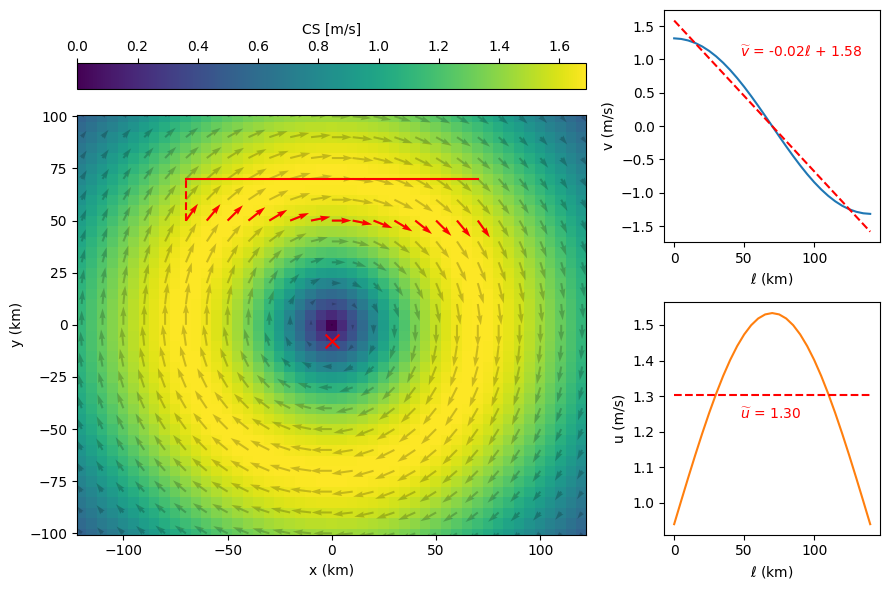

In [26]:
import matplotlib.gridspec as gridspec

# GridSpec for custom layout
fig = plt.figure(figsize=(9, 6))
gs = gridspec.GridSpec(2, 3, figure=fig)

# Large 3x3 subplot
ax_main = fig.add_subplot(gs[:, :2])
pc = ax_main.pcolor(x, y, np.hypot(u, v))
spacing = 2
scale = 40
width = 0.004
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)
ax_main.quiver(xx[::spacing], yy[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color='r')
ax_main.scatter(x0, y0, color='r', marker='x', s=100, label='MOCA Result')
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [m/s]')

ax_main.plot(xx, yy + 20, color='r')
ax_main.plot([xx[0], xx[0]], [yy[0], yy[0] + 20], color='r', linestyle='--')


ax_main.axis('equal')
# ax_main.legend()
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')

# 3x1 subplot column
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 2])

# Subplot 2
coeffs_v = np.polyfit(l, v1, 1)
fit_line_v = np.poly1d(coeffs_v)
ax2.plot(l, v1, color=colors[0])
ax2.plot(l, fit_line_v(l), linestyle="--", color='r')
ax2.set_xlabel(r'$\ell$ (km)')
ax2.set_ylabel('v (m/s)')
ax2.text(0.35, 0.85, fr"$\widetilde{{v}}$ = {coeffs_v[0]:.2f}$\ell$ + {coeffs_v[1]:.2f}", transform=ax2.transAxes,
         fontsize=10, verticalalignment='top', color='r')


# Subplot 3
coeffs_u = np.polyfit(l, u1, 0)
fit_line_u = np.poly1d(coeffs_u)
ax3.plot(l, u1, color=colors[1])
ax3.plot(l, fit_line_u(l), linestyle="--", color='r')
ax3.set_xlabel(r'$\ell$ (km)')
ax3.set_ylabel('u (m/s)')
ax3.text(0.35, 0.55, fr"$\widetilde{{u}}$ = {coeffs_u[0]:.2f}", transform=ax3.transAxes,
         fontsize=10, verticalalignment='top', color='r')

plt.tight_layout()
plt.show()





In [11]:
x0

np.float64(0.0)

In [12]:
y0

array([-7.61412232])

In [13]:
v

array([[ 4.13018666e-05,  5.29002342e-05,  6.74177111e-05, ...,
         6.74177111e-05,  5.29002342e-05,  4.13018666e-05],
       [ 4.64993595e-05,  5.95572817e-05,  7.59016608e-05, ...,
         7.59016608e-05,  5.95572817e-05,  4.64993595e-05],
       [ 5.80274803e-05,  7.43227184e-05,  9.47191971e-05, ...,
         9.47191971e-05,  7.43227184e-05,  5.80274803e-05],
       ...,
       [-5.80274803e-05, -7.43227184e-05, -9.47191971e-05, ...,
        -9.47191971e-05, -7.43227184e-05, -5.80274803e-05],
       [-4.64993595e-05, -5.95572817e-05, -7.59016608e-05, ...,
        -7.59016608e-05, -5.95572817e-05, -4.64993595e-05],
       [-4.13018666e-05, -5.29002342e-05, -6.74177111e-05, ...,
        -6.74177111e-05, -5.29002342e-05, -4.13018666e-05]])